<a href="https://colab.research.google.com/github/spirit9100/Learning_project/blob/main/41_YOLO_%D0%BE%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

1. Используйте модель YOLOv3 из урока, а также вспомогательные функции урока, обучите модель детектировать шахматные фигуры.  Модель создайте с нуля.
2. Обеспечьте, чтобы изображения на выходе сети восстанавливались до своего первоначального размера, при этом необходимо, чтобы размер предсказанных ограничивающих рамок, так же правильно трансформировался под размер изображения.
3. Продемонстрируйте работу сети на изображениях разного размера, как альбомной, так и портретной ориентации.

# Импорт библиотек

In [ ]:
!pip install --upgrade keras

In [ ]:
# Обработка изображений
import cv2
from PIL import Image, ImageDraw

import os

# Линейная алгебра
import numpy as np

# Графики
from matplotlib import pyplot as plt

# Работаем с фреймворком Keras и Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

from itertools import repeat

# Датасет

## Загрузка

In [ ]:
!wget -nc https://storage.yandexcloud.net/study.doc/Chess%20Pieces.v24-416x416_aug.yolokeras.zip

File ‘Chess Pieces.v24-416x416_aug.yolokeras.zip’ already there; not retrieving.



Датасет состоит из 693 аугументированных изображений. Для аугументации было взято 289 изображений.  

Датасет разделен на 3 группы: тренировочная (train), проверочная (valid) и тестовая (test).  
Каждая группа состоит из:  
  - Файлы изображения размера 416*416
  - _annotations.txt - файл содержит список имен фалов группы с координатами рамок (Xmin, Ymin, Xmax, Ymax) и классом выделенного объекта. Для одного изображения может быть несколько рамок
  - _classes.txt - текстовый список классов.

Всего в наборе данных используется 13 классов:
  - bishop
  - black-bishop
  - black-king
  - black-knight
  - black-pawn
  - black-queen
  - black-rook
  - white-bishop
  - white-king
  - white-knight
  - white-pawn
  - white-queen
  - white-rook


In [ ]:
DATASET_PATH = 'chess_yolo'
TRAIN_PATH = os.path.join(DATASET_PATH,'train')
VAL_PATH = os.path.join(DATASET_PATH,'valid')
TEST_PATH = os.path.join(DATASET_PATH,'test')


In [ ]:
def resize_img_and_boxes(img, bound, size:tuple = (416,416)):
    '''Изменение размера изображения с неизменным соотношением сторон с помощью отступов'''
    # размер исходного изображения
    tmp_bound = np.copy(bound)
    iw, ih = img.size
    # размер до которого изменяем
    w, h = size
    # масштаб
    scale = min(w/iw, h/ih)

    # новые ширина и высота
    nw = int(iw*scale)
    nh = int(ih*scale)

    # сдвиг по ширине и высоте
    dx = (w-nw)//2
    dy = (h-nh)//2

    # скалирование рамки

    tmp_bound[:,[0,2]] =  tmp_bound[:,[0,2]]*scale + dx
    tmp_bound[:,[1,3]] =  tmp_bound[:,[1,3]]*scale + dy

    img = img.resize((nw,nh), Image.BICUBIC)
    #  Новое изображени с серым фоном
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(img, (dx, dy))

    return new_image, tmp_bound

In [ ]:
def draw_bounds(img, boxes):
  draw = ImageDraw.Draw(img)
  for box in boxes:
    Xmin,Ymin,Xmax,Ymax = box[:4]
    draw.rectangle([ Xmin,Ymin,Xmax,Ymax], outline="red", width=2, fill=None)
  return img

In [ ]:
!unzip -n 'Chess Pieces.v24-416x416_aug.yolokeras.zip' -d 'chess_yolo'

Archive:  Chess Pieces.v24-416x416_aug.yolokeras.zip


In [ ]:
# file = '_annotations.txt'
# images=[]
# bounds =[]
# max_length = 0 #Максимальное количество рамок для изображения
# with open(os.path.join(TRAIN_PATH, file),'r') as f:
#   # Разделение файла построчно
#   for line in f.readlines():
#     # разбиваем строку по пробелам на имя файла и рамки
#     split_line = line.split()

#     if len(split_line[1:])> max_length: max_length = len(split_line[1:])

#     boxes = np.array([np.array(list(box.split(',')), dtype=int) for box in split_line[1:]])

#     img = Image.open(os.path.join(TRAIN_PATH,split_line[0]))
#     images.append(img)
#     bounds.append(boxes)
# test = np.zeros((len(images),max_length,5))
# for i, box in enumerate(bounds):
#   test[i][:box.shape[0]] = box

In [ ]:
def get_data(path, count=None):
  file = '_annotations.txt'
  images=[]
  bounds =[]
  max_length = 20
  with open(os.path.join(path, file),'r') as f:
    # Разделение файла построчно
    for line in f.readlines()[:count]:
      # разбиваем строку по пробелам на имя файла и рамки
      split_line = line.split()

      if len(split_line[1:])> max_length: max_length = len(split_line[1:])

      boxes = [np.array(list(box.split(',')), dtype=int) for box in split_line[1:]]

      img = Image.open(os.path.join(path,split_line[0]))
      images.append(img)
      bounds.append(boxes)

  boxes = np.zeros((len(images),max_length,5), dtype='float32')

  for i, box in enumerate(bounds):
    boxes[i][:len(box)] = box

  return images, boxes


## Визуализация

In [ ]:
x_train, y_train = get_data(TRAIN_PATH, count=4)

In [ ]:
y_train.shape

(4, 20, 5)

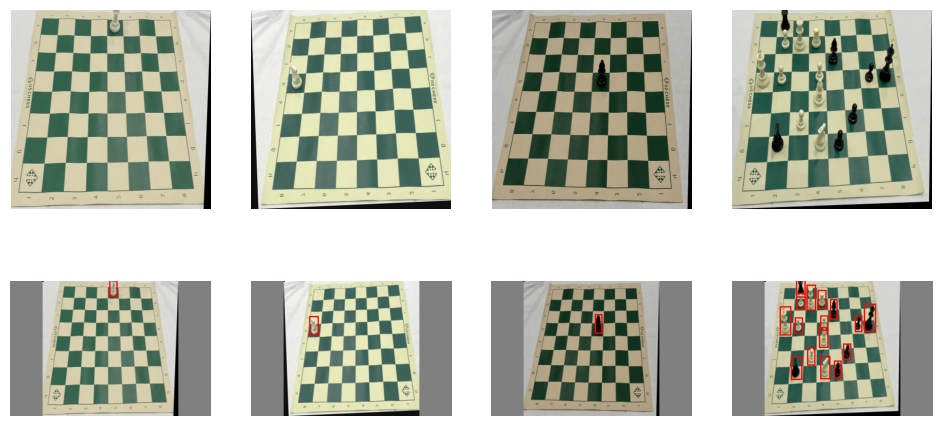

In [ ]:
plt.figure(figsize=(15,15))

for i, img in enumerate(x_train[:5]):
  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.subplot(5,5,i+6)
  resize_img, box1 = resize_img_and_boxes(img, y_train[i], size=(308,208))

  plt.imshow(draw_bounds(resize_img, box1))
  plt.axis('off')



# Дополнительные функции

## Блоки модели

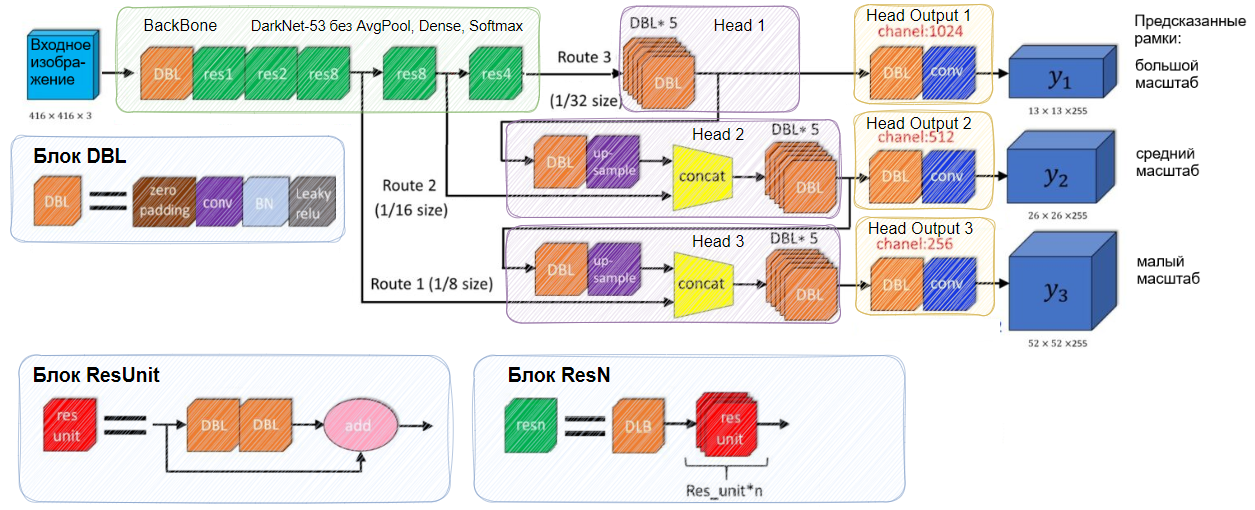

**Рис. Архитектура YOLOv3**

In [ ]:
def DBL(x, filters, kernel, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        # Делаем oтступ в виде нулей по контуру изображения, что бы захватить левый верхний угол
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=kernel,
              strides=strides, padding=padding,
              use_bias=not batch_norm,  # используем смещение, если нет нормализации
              kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization(epsilon=0.001)(x)
        x = LeakyReLU(negative_slope=0.1)(x)
    return x

In [ ]:
def ResUnit(x, filters):
    skip_connection  = x
    x = DBL(x, filters // 2, 1)
    x = DBL(x, filters, 3)
    x = Add()([skip_connection , x])
    return x

In [ ]:
def ResN(x, filters, blocks):
    x = DBL(x, filters, kernel=3, strides=2)
    for _ in repeat(None, blocks): # цикл по n-блокам (подход с repeat позволяет экономить память)
        x = ResUnit(x, filters)
    return x

## Backbone(Позвоночник)

In [ ]:
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DBL(x, 32, 3)
    x = ResN(x, 64, 1)
    x = ResN(x, 128, 2)
    x = Route_1 = ResN(x, 256, 8)
    x = Route_2 = ResN(x, 512, 8)
    Route_3 = ResN(x, 1024, 4)
    return tf.keras.Model(inputs, (Route_1, Route_2, Route_3), name=name)

## Head (Головы) YOLO

In [ ]:
def YoloHead(filters, name=None):
    def layer(x_in):
        if isinstance(x_in, tuple): #
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            x = DBL(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return layer

def YoloHeadOutput(filters, anchors, classes, name=None):
    def layer(x_in):

        x = inputs = Input(x_in.shape[1:])
        x = DBL(x, filters * 2, 3)
        x = DBL(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return layer

## Рамки

In [ ]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

In [ ]:
def yolo_boxes(pred, anchors, classes):
    # На входе pred размера (S, S, 3, (1+4+80))
    anchors = tf.convert_to_tensor(anchors, dtype=tf.float32)
    grid_size = tf.shape(pred)[1] # S ячеек в сетке

    # В box_xy и box_wh помещаем сразу по 2 переменные (tx, ty) и (tw, th)
    box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1) # раскладываем предсказанную карту по переменным

    # Применяем сигмоидные функции
    box_xy = tf.sigmoid(box_xy)
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)


    # Построим сетку S x S
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

    # Привяжем box_xy к ячейкам сетки, учтем смещения (и снова нормируем к диапазону 0, 1)
    # Фактически мы вычисляем центральное положение рамки относительно размеров сетки (якорного поля)
    b_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32) # вычисляем b_xy: (bx, by)

    b_wh = tf.exp(box_wh) * anchors # вычисляем b_wh: (bw, bh), ширина и высота рамки bbox

    box_x1y1 = b_xy - b_wh / 2
    box_x2y2 = b_xy + b_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1) # задаем рамку bbox, как 2 координаты углов


    return bbox, score, class_probs, pred_box

In [ ]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    # Блок преобразования трех выходов разных масштабов
    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

    # Конкатенируем три масштаба в один
    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    scores = confidence * class_probs # Оценки считаем как произведение оценок объектности на вероятности классов

    # Применяем NMS из пакета tensorflow (работаем с документацией, смотрим параметры самостоятельно: https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=YOLO_IOU_THRESHOLD,
        score_threshold=YOLO_SCORE_THRESHOLD)

    return boxes, scores, classes, valid_detections

## Функция вычисления IoU

In [ ]:
@tf.function
def interval_overlap(interval_1, interval_2):
    # print(interval_1, interval_2)
    x1, x2 = interval_1
    x3, x4 = interval_2
    if x3 < x1:
        return 0 if x4 < x1 else (min(x2,x4) - x1)
    else:
        return 0 if x2 < x3 else (min(x2,x4) - x3)

In [ ]:
def intersectionOverUnion_old(box1, box2): # box1, box2 - координаты рамки
    b1 = tf.expand_dims(box1, -2)
    b2 = tf.expand_dims(box2, 0)
    box1_xmin, box1_xmax = b1[...,0], b1[...,2]
    box1_ymin, box1_ymax = b1[...,1], b1[...,3]

    box2_xmin, box2_xmax = b2[...,0], b2[...,2]
    box2_ymin, box2_ymax = b2[...,1], b2[...,3]

    intersect_w = interval_overlap([box1_xmin, box1_xmax], [box2_xmin, box2_xmax])
    intersect_h = interval_overlap([box1_ymin, box1_ymax], [box2_ymin, box2_ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1_xmax - box1_xmin, box1_ymax - box1_ymin
    w2, h2 = box2_xmax - box2_xmin, box2_ymax - box2_ymin

    union_area = w1*h1 + w2*h2 - intersect_area
    if union_area == 0:
        return 0.0
    return float(intersect_area) / union_area # возвращает значение IoU



def intersectionOverUnion(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

## Функция потерь

Функция ошибки состоит из четырех частей:

xy_loss - ошибка положения (xy)
wh_loss - ошибка ширины и высоты(wh)
obj_loss - ошибка объектности (наличие объекта в ячейке)
class_loss - ошибка классификации

In [ ]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):

        # 1. Преобразуем все предсказанные выходы
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        # с функцией yolo_boxes мы уже знакомы
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. Преобразуем все реальные значения
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # Чем меньше рамка, тем больше ошибка
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. Инвертируем  уравнений красного прямоугольника inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                      tf.zeros_like(true_wh), true_wh)

        # 4. Вычисляем ignore_mask
        obj_mask = tf.squeeze(true_obj, -1)
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(intersectionOverUnion(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. Вычисляем все функции ошибок
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)

        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss

        # Можно использовать как binary_crossentropy, так и sparse_categorical_crossentropy
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. Все функции ошибок суммируются по осям для каждого пакета (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        # Общая суммарная ошибка
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

## Преобразование ограничивающих рамок

In [ ]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    N = tf.shape(y_true)[0]

    y_true_out = tf.zeros( (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 0, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 0, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))
            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    if tf.size(indexes.stack()) > 0:
      # tf.print(indexes.stack(), updates.stack())
      y_true_out = tf.tensor_scatter_nd_update(y_true_out, indexes.stack(), updates.stack())
    return y_true_out


def transform_targets(y_train, anchors, anchor_masks):
    outputs = []
    grid_size = 13

    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]

    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2), (1, 1, tf.shape(anchors)[0], 1))

    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)
    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
    return (tf.image.resize(x_train, (size, size))) / 255

## Загрузка весов

In [ ]:
# The function to load weights from pretrained model

def load_darknet_weights(model, weights_file):

    wf = open(weights_file, 'rb') # загружаем файл

    # Читаем из файла по элементам (первые 5, версия файла)
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLO_V3_LAYERS # слои для загрузки

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)      # извлекаем блоки слоев из модели по имени
        for i, layer in enumerate(sub_model.layers): # пробегаемся по отдельным слоям блоков
            if not layer.name.startswith('conv2d'):  # пропускаем не сверточные слои
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                sub_model.layers[i + 1].name.startswith('batch_norm'):
                    batch_norm = sub_model.layers[i + 1]  # фиксируем если за слоем будет батч-нормализация



            filters = layer.filters                   # фильтров в слое
            size = layer.kernel_size[0]               # размер ядра в слое
            #in_dim = layer.input_shape[-1]           # input_shape в слоях Conv2d больше не поддерживается
            in_dim = layer.get_weights()[0].shape[2]  # входная размерность слоя

            # Вспоминаем структуру DBL: если нет нормализации, то добавляется смещение
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters) # считываем веса для смещения
            else:
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4*filters) # считываем веса для нормализации
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]     # меняем форму

            conv_shape = (filters, in_dim, size, size)    # размерности сверточного слоя
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.prod(conv_shape))  # считываем веса для сверточного слоя
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0]) # меняем форму данных весов, решейпим и транспонируем

            # Если нет нормализации, то добавляем веса + смещение
            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                # Если есть нормализации, то добавляем веса в сверточный слой и в следующий за ним слой нормализации
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read weights'   # генерируем исключение, если файл не читается
    wf.close()

# Параметры

In [ ]:
YOLO_IOU_THRESHOLD = 0.6 # порог для оценок перекрытия IOU в NMS (параметр iou_threshold в tf.image.combined_non_max_suppression)
YOLO_SCORE_THRESHOLD = 0.6 # порог для оценок scores применяется в NMS (параметр score_threshold в tf.image.combined_non_max_suppression)

WEIGHT_YOLO_V3 = 'yolov3.weights' # путь к файлу с предобученными весами
SIZE = 416 # изменяем изображения до размеров
CHECKPOINTS = 'yolov3.weights.h5' # путь сохранения весов модели
NUM_CLASSES = 13 # число классов, на которых обучена модель

In [ ]:
YOLO_V3_LAYERS = [
    'yolo_darknet',
    'yolo_head_1',
    'yolo_output_1',
    'yolo_head_2',
    'yolo_output_2',
    'yolo_head_3',
    'yolo_output_3'
]

In [ ]:
CLASSES = ['слон', 'черный слон', 'черный король', 'черный рыцарь', 'черная пешка',
           'черная королева', 'черная ладья', 'белый слон', 'белый король',
           'белый рыцарь', 'белая пешка', 'белая королева', 'белая ладья']

# Модель

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
            masks=yolo_anchor_masks, classes=13, training=False):
    # Вход
    x = inputs = Input([size, size, channels])

    # Модель Darknet с тремя выходами
    Route_1, Route_2, Route_3 = Darknet(name='yolo_darknet')(x)

    # Определяем 3 головы с разным числом фильтров
    x = YoloHead(512, name='yolo_head_1')(Route_3)
    output_0 = YoloHeadOutput(512, len(masks[0]), classes, name='yolo_output_1')(x)

    x = YoloHead(256, name='yolo_head_2')((x, Route_2))
    output_1 = YoloHeadOutput(256, len(masks[1]), classes, name='yolo_output_2')(x)

    x = YoloHead(128, name='yolo_head_3')((x, Route_1))
    output_2 = YoloHeadOutput(128, len(masks[2]), classes, name='yolo_output_3')(x)

    if training: # заложим модель для обучения (понадобиться в домашней работе)
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    # Перегоняем предсказанные якорные рамки в boundary box для трех выходов
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

    # Отсекаем все лишнее алгоритмом NMS
    outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3') # возвращаем модель для инференса

# Обучение модели

## Перенос весов Darknet

In [ ]:
yolo = YoloV3(classes=80)

load_darknet_weights(yolo, WEIGHT_YOLO_V3)

In [ ]:
yolo_chess = YoloV3(classes=NUM_CLASSES, training=True)

In [ ]:
def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [ ]:
yolo_chess.get_layer('yolo_darknet').set_weights(yolo.get_layer('yolo_darknet').get_weights())
freeze_all(yolo_chess.get_layer('yolo_darknet'))

In [ ]:
del yolo

## Компиляция модели

In [ ]:
from tensorflow.keras.optimizers import Adam
yolo_chess.compile(optimizer=Adam(learning_rate=1e-4), loss={
    'yolo_output_1':YoloLoss(anchors=yolo_anchors[yolo_anchor_masks[0]], classes=NUM_CLASSES),
    'yolo_output_2':YoloLoss(anchors=yolo_anchors[yolo_anchor_masks[1]], classes=NUM_CLASSES),
    'yolo_output_3':YoloLoss(anchors=yolo_anchors[yolo_anchor_masks[2]], classes=NUM_CLASSES)
    })

In [ ]:
yolo_chess.summary()

Model: "yolov3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ yolo_darknet (Functional) │ [(None, None, None,    │     40,620,640 │ input_layer_10[0][0]   │
│                           │ 256), (None, None,     │                │                        │
│                           │ None, 512), (None,     │                │                        │
│                           │ None, None, 1024)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ yolo_head_1 (Functional)  │ (None, None, None,     │     11,024,384 │ yolo_darknet[0][2]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ yolo_head_2 (Functional)  │ (None, None, None,     │      2,957,312 │ yolo_head_1[0][0],     │
│                           │ 256)                   │                │ yolo_darknet[0][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ yolo_head_3 (Functional)  │ (None, None, None,     │        741,376 │ yolo_head_2[0][0],     │
│                           │ 128)                   │                │ yolo_darknet[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ yolo_output_1             │ (None, None, None, 3,  │      4,778,038 │ yolo_head_1[0][0]      │
│ (Functional)              │ 18)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ yolo_output_2             │ (None, None, None, 3,  │      1,209,398 │ yolo_head_2[0][0]      │
│ (Functional)              │ 18)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ yolo_output_3             │ (None, None, None, 3,  │        309,814 │ yolo_head_3[0][0]      │
│ (Functional)              │ 18)                    │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,640,962 (235.14 MB)

 Trainable params: 21,003,426 (80.12 MB)

 Non-trainable params: 40,637,536 (155.02 MB)

## Формирование датасета для обучения

In [ ]:
BATCH_SIZE = 1

In [ ]:
x_train, y_train = get_data(TRAIN_PATH)
x_train = np.array(x_train)/255
y_train[...,:4] = y_train[...,:4]/416

In [ ]:
# y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(BATCH_SIZE)

In [ ]:
train_ds = train_ds.map(lambda x, y: (x, transform_targets(y, yolo_anchors, yolo_anchor_masks)))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
x_train, y_train = None, None

In [ ]:
x_val,y_val = get_data(VAL_PATH)
x_val = np.array(x_val)/255
y_val[...,:4] = y_val[...,:4]/416

In [ ]:
ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.map(lambda x, y: (x, transform_targets(y, yolo_anchors, yolo_anchor_masks)))
ds_val = ds_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
x_val,y_val = None, None

## Тренировка модели

In [ ]:
yolo_chess.fit(train_ds, validation_data=ds_val,epochs=30)


Epoch 1/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 4.3351 - yolo_output_1_loss: 6.8096e-04 - yolo_output_2_loss: 0.6196 - yolo_output_3_loss: 0.4202 - val_loss: 10.2504 - val_yolo_output_1_loss: 5.2201e-04 - val_yolo_output_2_loss: 4.1336 - val_yolo_output_3_loss: 2.8288
Epoch 2/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - loss: 4.0141 - yolo_output_1_loss: 4.4427e-04 - yolo_output_2_loss: 0.4321 - yolo_output_3_loss: 0.3054 - val_loss: 13.1705 - val_yolo_output_1_loss: 3.2068e-04 - val_yolo_output_2_loss: 5.9222 - val_yolo_output_3_loss: 4.0053
Epoch 3/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 3.7219 - yolo_output_1_loss: 3.3415e-04 - yolo_output_2_loss: 0.2694 - yolo_output_3_loss: 0.2266 - val_loss: 12.5628 - val_yolo_output_1_loss: 2.6363e-04 - val_yolo_output_2_loss: 4.7768 - val_yolo_output_3_loss: 4.6191
Epoch 4/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 3.5245 - yolo_output_1_loss: 2.6589e-04 - yolo_output_2_loss: 0.2281 - yolo_output_3_loss

In [ ]:
yolo_chess.save_weights('chess_yolo.weights.h5')

# Проверка

Надо сменить среду выполнения на CPU, и выполнить блоки до обучение модели

## Функции детекции объектов и отображения предсказанной рамки

In [ ]:
!wget -nc https://storage.yandexcloud.net/study.doc/chess_yolo.weights.h5
!wget -nc https://storage.yandexcloud.net/study.doc/test_image.zip

--2024-10-24 20:53:46--  https://storage.yandexcloud.net/study.doc/chess_yolo.weights.h5
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 415334760 (396M) [application/x-www-form-urlencoded]
Saving to: ‘chess_yolo.weights.h5.1’

chess_yolo.weights. 100%[===================>] 396.09M  10.1MB/s    in 40s     

2024-10-24 20:54:24 (10.0 MB/s) - ‘chess_yolo.weights.h5.1’ saved [415334760/415334760]

--2024-10-24 20:54:24--  https://storage.yandexcloud.net/study.doc/test_image.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191517 (1.1M) [application/x-zip-compressed]
Saving to: ‘test_image.zip

In [ ]:
!unzip -n 'test_image.zip'

Archive:  test_image.zip
  inflating: 1.jpg                   


In [ ]:
def draw_outputs(img, outputs, class_names, white_list=None):

    boxes, score, classes, nums = outputs # распознанные объекты

    boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2]) # предсказанные ширина и высота
    for i in range(nums):
        # Отображаем объекты только из white_list
        if class_names[int(classes[i])] not in white_list:
            continue

        # Предсказанные координаты нижнего левого и правого верхнего углов
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))

        # Рисуем прямоугольник по двум предсказанным координатам
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 1)

        # Выводим имя класса предсказанного объекта и оценку
        img = cv2.putText(img, '{} {:.2f}'.format(
            class_names[int(classes[i])], score[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 1)
    return img


def detect_objects(img_path, model, class_names, white_list=None):
    image = img_path # путь к файлу
    img = tf.image.decode_image(open(image, 'rb').read(), channels=3) # загружаем изображение как тензор

    img = tf.expand_dims(img, 0) # добавляем размерность
    img = preprocess_image(img, SIZE) # ресайзим изображение

    boxes, scores, classes, nums = model.predict(img) # делаем предсказание

    img = cv2.imread(image) # считываем изображение как картинку, чтобы на нем рисовать
    # Отрисовываем на картинке предсказанные объекты
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names, white_list)

    # Сохраняем изображения с предсказанными объектами
    cv2.imwrite('detected_{:}'.format(img_path), img)

    # Открываем сохраненные изображения и выводим на экран
    detected = Image.open('detected_{:}'.format(img_path))
    detected.show()
    plt.imshow(detected)

In [ ]:
yolo1 = YoloV3(classes=NUM_CLASSES, training=False)

In [ ]:
yolo1.load_weights('chess_yolo.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


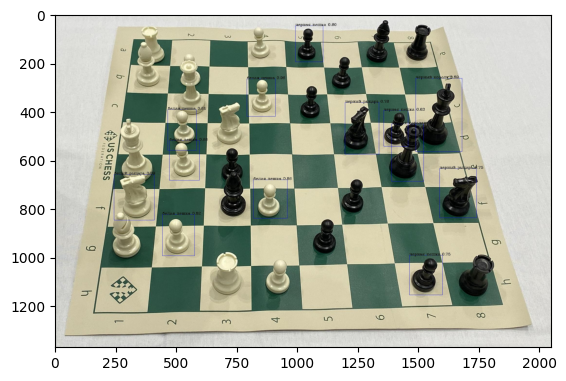

In [ ]:
detect_objects('1.jpg',yolo1, CLASSES, white_list=CLASSES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


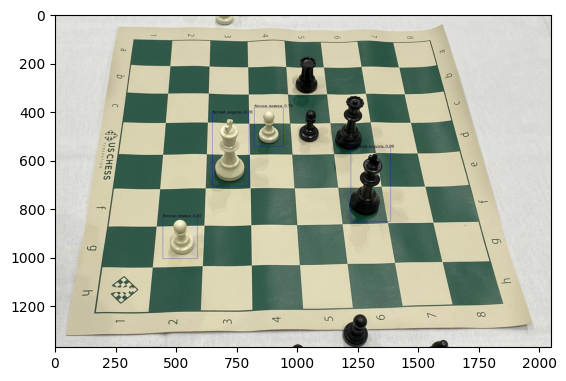

In [ ]:
detect_objects('2.jpg',yolo1, CLASSES, white_list=CLASSES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


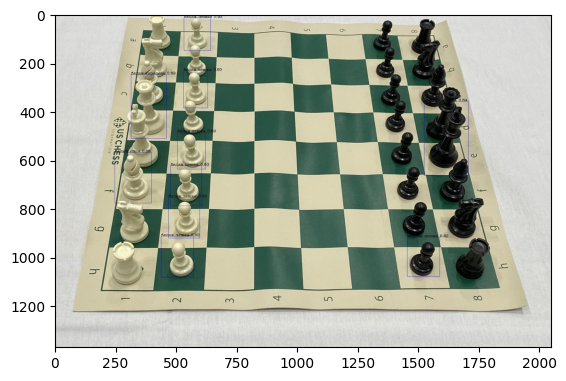

In [ ]:
detect_objects('3.jpg',yolo1, CLASSES, white_list=CLASSES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


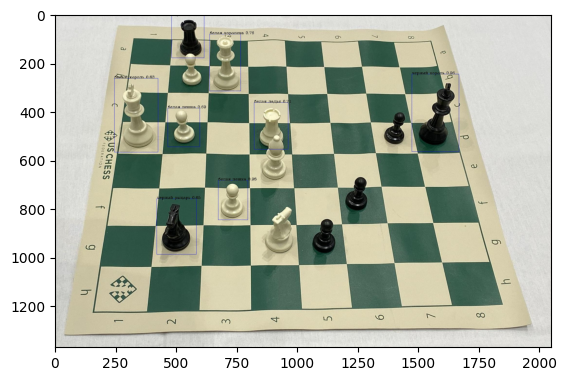

In [ ]:
detect_objects('4.jpg',yolo1, CLASSES, white_list=CLASSES)

Как мы видим модель еще нуждается в до тренировке так как не всегда находит объекты. Для улучшения надо будет использовать дополнительную аугументацию изображений и генераторы для набора данных. Так же можно попробывать разморозить веса слоя Darknet, но это потребует больших ресурсов для тренировки модели.

